In [131]:
from maliboo import BayesianOptimization, UtilityFunction
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec

import pandas as pd
import time
%matplotlib inline

In [132]:
# Townsend
def target(x,y):
    return -(-np.cos((x-0.1)*y)**2-x*np.sin(3*x+y))

In [133]:
def constraint(x,y):
    return x**2+y**2-(2*np.cos(np.arctan2(x,y))-0.5*np.cos(2*np.arctan2(x,y))-0.25*np.cos(3*np.arctan2(x,y))-0.125*np.cos(4*np.arctan2(x,y)))**2-(2*np.sin(np.arctan2(x,y)))**2

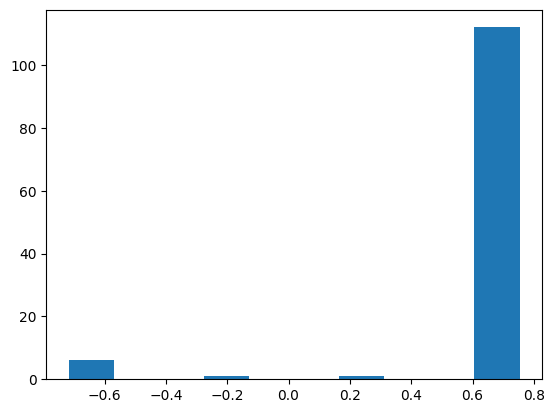

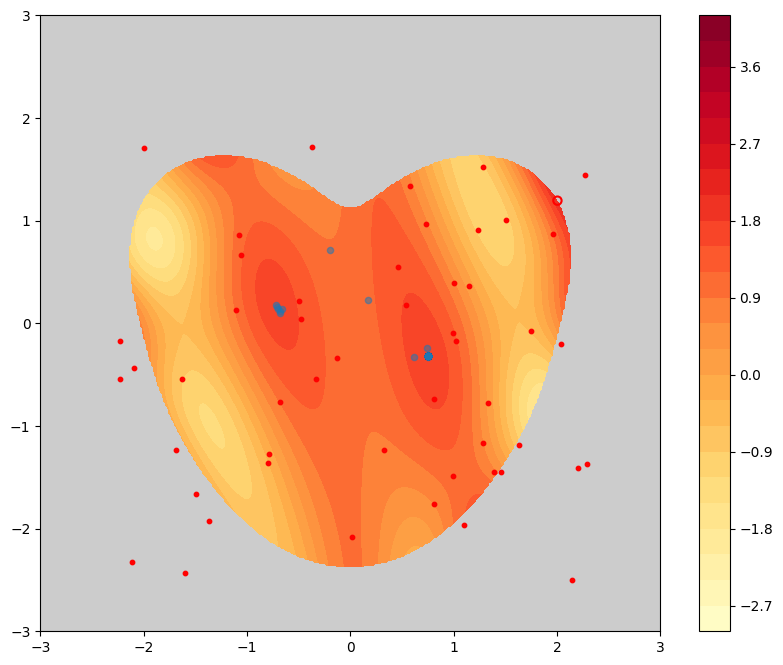

In [130]:
resultsdf = pd.read_csv('results.csv', usecols=['x','y','target'])
first50 = pd.read_csv('results.csv', usecols=['x','y']).iloc[:50]
resultsdf = resultsdf.iloc[50:].reset_index(drop = True)

mask = np.where(resultsdf['target'] <= 2.002)[0]
x_iter = resultsdf['x']#.iloc[mask]
y_iter = resultsdf['y']#.iloc[mask]
plt.hist(x_iter)
# meshgrid
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)

Z_target = target(X, Y)
Z_constraint = constraint(X, Y)

# target contour levels
plt.figure(figsize=(10, 8))
contour_target = plt.contourf(X, Y, Z_target, levels=25,cmap='YlOrRd') # Use 100 levels for smooth gradients
plt.colorbar(contour_target)

# constraint contour levels (only 2: >0 or <=0)
# grey for <= 0, transparent for > 0
plt.contourf(X, Y, Z_constraint <= 0, levels=[-np.inf, 0, np.inf], colors=['0.8', 'none'])
plt.scatter(x_iter, y_iter, s=20, alpha = 0.5)
plt.scatter(2.0052938, 1.1944509, edgecolors='red', facecolors='none', linewidths=1.5)
plt.scatter(first50['x'],first50['y'],s = 10, color = 'red')


# Converging case (acq = 'eb', 1/sigma)

In [136]:
import warnings
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y, show_minimized=False, style='transparent'):

    if style == 'classic':
        plt.style.use(style)
    elif style == 'dark':
        plt.style.use('dark_background')
    elif style == 'transparent':
        pass
    else:
        raise ValueError("Wrong style")

    # Swap sign of stuff
    sign = -1 if show_minimized else 1
    
    # Set up complete plot
    plt.rcParams.update({'font.size': 20})

    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    ## MAIN PLOT
    # Plot true objective
    target_col = 'limegreen' if style == 'dark' else 'gray'
    axis.plot(x, sign*y, linewidth=3.5, label='objective function',
              color=target_col)
    # Plot observations
    x_obs = np.array([[res["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    axis.scatter(x_obs, sign*y_obs, marker='o', s=300,
                 label='observations', color='red', zorder=10)   
    # Plot mean function
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    mu = sign * mu
    axis.plot(x, mu, dashes=(12, 3.5), color='blue', lw=2.5, label='mean prediction')
    # Plot credible interval
    quant = 1.96
    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - quant * sigma, (mu + quant * sigma)[::-1]]),
        alpha=.6, fc='paleturquoise', ec='None', label='95% credible interval')
    # Set parameters
    xlim = (-2,10)
    axis.set_xlim(xlim)
    axis.set_xlabel('x')
    axis.set_ylim(-1.61, 0.01)
    axis.set_ylabel('objective function')
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

    ## ACQUISITION PLOT
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    x_next = x[np.argmax(utility)]
    print(x_next)
    acq.plot(x, utility, label='acquisition function', lw=2, color='fuchsia')
    acq.scatter(x_next, np.max(utility), marker='x', s=300, 
             label='next observation', ec='red', lw=4, zorder=10)
    acq.set_xlim(xlim)
    acq.set_ylim((0, 2.501))
    acq.set_ylabel('utility')
    acq.set_xlabel('x')
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1))

    # Vertical lines in both
    axis.vlines(x_next, sign*0, sign*1.6, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')
    acq.vlines(x_next,       0,        5, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')

    # Overlay vertical Gaussian distribution
    ypos_idx = np.abs(x-x_next).argmin()
    ypos = mu[ypos_idx]
    var = 0.6 * sigma[ypos_idx]  # I'm cheating a little bit with the variance
                                 # for representation purposes
    bound = 0.5
    supp = np.linspace(-bound, bound, 1000).reshape(-1, 1)
    gaussian = np.exp((-supp ** 2.0) / (2 * var ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= -0.5  # height
    axis.plot(gaussian + x_next, supp + ypos, lw=1.5, color='silver')

    # Save to file
    for fmt in ('png', 'svg'):
        filename = f'bo_{style}_{len(x_obs)}.{fmt}'
        plt.savefig(os.path.join('resources', filename), bbox_inches='tight', dpi=300)

# with these values it converges seed = 27222
optimizer = BayesianOptimization(target, {'x': (-2.25,2.5),'y': (-2.5,1.75)}, 
                                 random_state=27222,
                                 barrier_func={'constraint1': lambda x,y: x**2+y**2-(2*np.cos(np.arctan2(x,y))-0.5*np.cos(2*np.arctan2(x,y))-0.25*np.cos(3*np.arctan2(x,y))-0.125*np.cos(4*np.arctan2(x,y)))**2-(2*np.sin(np.arctan2(x,y)))**2},
                                 debug = True)
# Other rounds of optimization
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    warnings.simplefilter("ignore", FutureWarning)
    optimizer.maximize(init_points=50, n_iter=120,acq='eb',acq_info={'static_lambda':False})
    # optimizer.maximize(init_points=50, n_iter=120,acq='eic_bm',acq_info={'static_lambda':True, 'lam':10})

Initializing TargetSpace with bounds: {'x': (-2.25, 2.5), 'y': (-2.5, 1.75)}
initialize_dataset(): dataset is None
TargetSpace initialization completed
BayesianOptimization initialization completed
Starting maximize()
|   iter    |  target   |     x     |     y     |
-------------------------------------------------
_prime_queue(): initializing 50 random points
Uniform randomly sampled point: value [[ 1.18035032 -1.83222497]]
Uniform randomly sampled point: value [[-1.01028192 -2.15771642]]
Uniform randomly sampled point: value [[ 0.35257473 -1.76445162]]
Uniform randomly sampled point: value [[0.6766644  1.62884233]]
Uniform randomly sampled point: value [[-1.5622215  -0.89778052]]
Uniform randomly sampled point: value [[-0.27774101 -1.53644378]]
Uniform randomly sampled point: value [[ 0.73316997 -1.67048958]]
Uniform randomly sampled point: value [[0.6358628  1.28281612]]
Uniform randomly sampled point: value [[-2.24108637 -0.64627599]]
Uniform randomly sampled point: value [[-0.463

first occurrence of maximum at iteration: 119


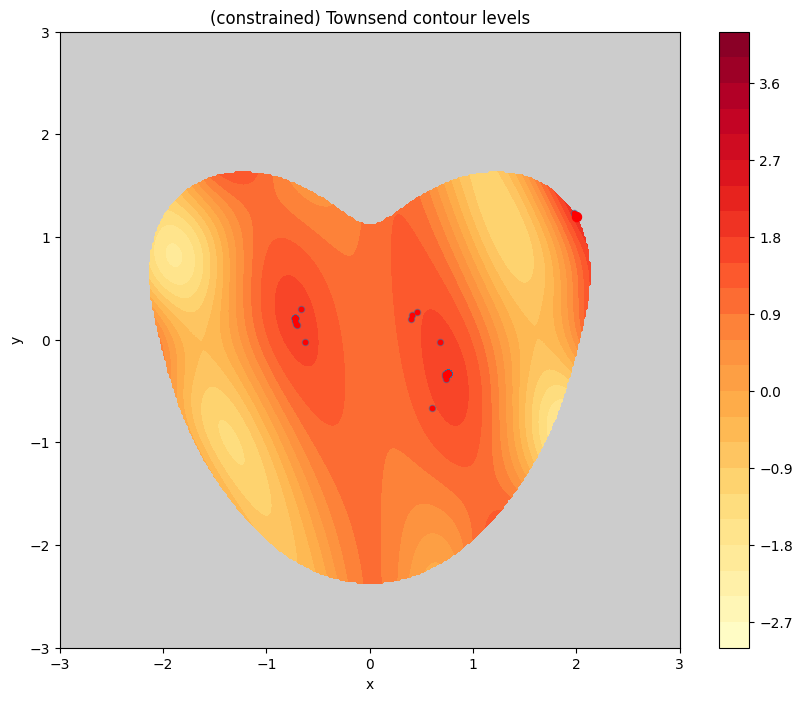

In [ ]:
results_df = pd.read_csv('results.csv', usecols=['x','y','target'])
first50 = results_df.iloc[:50]
results_df = results_df.iloc[50:].reset_index(drop = True)
print(f'first occurrence of maximum at iteration: {np.where(results_df['target'] == optimizer.max['target'])[0][0]}')
valid_mask = np.where(results_df['target'] <= optimizer.max['target'])[0]
x_iter = results_df['x'].iloc[valid_mask]
y_iter = results_df['y'].iloc[valid_mask]

sampled = [x_iter, y_iter]
# meshgrid
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)

Z_target = target(X, Y)
Z_constraint = constraint(X, Y)

# target contour levels
plt.figure(figsize=(10, 8))
contour_target = plt.contourf(X, Y, Z_target, levels=25,cmap='YlOrRd') # Use 100 levels for smooth gradients
plt.colorbar(contour_target)

# constraint contour levels (only 2: >0 or <=0)
# grey for <= 0, transparent for > 0
plt.contourf(X, Y, Z_constraint <= 0, levels=[-np.inf, 0, np.inf], colors=['0.8', 'none'])
plt.scatter(x_iter, y_iter, s=20, alpha = 0.5)
plt.scatter(2.0052938, 1.1944509, edgecolors='red', facecolors='none', linewidths=1.5)
plt.scatter(first50['x'], first50['y'], s = 10, color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('(constrained) Townsend contour levels')
plt.show()

# (acq = 'eb', fixed gamma = 1e6)

In [ ]:
import warnings
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y, show_minimized=False, style='transparent'):

    if style == 'classic':
        plt.style.use(style)
    elif style == 'dark':
        plt.style.use('dark_background')
    elif style == 'transparent':
        pass
    else:
        raise ValueError("Wrong style")

    # Swap sign of stuff
    sign = -1 if show_minimized else 1
    
    # Set up complete plot
    plt.rcParams.update({'font.size': 20})

    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    ## MAIN PLOT
    # Plot true objective
    target_col = 'limegreen' if style == 'dark' else 'gray'
    axis.plot(x, sign*y, linewidth=3.5, label='objective function',
              color=target_col)
    # Plot observations
    x_obs = np.array([[res["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    axis.scatter(x_obs, sign*y_obs, marker='o', s=300,
                 label='observations', color='red', zorder=10)   
    # Plot mean function
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    mu = sign * mu
    axis.plot(x, mu, dashes=(12, 3.5), color='blue', lw=2.5, label='mean prediction')
    # Plot credible interval
    quant = 1.96
    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - quant * sigma, (mu + quant * sigma)[::-1]]),
        alpha=.6, fc='paleturquoise', ec='None', label='95% credible interval')
    # Set parameters
    xlim = (-2,10)
    axis.set_xlim(xlim)
    axis.set_xlabel('x')
    axis.set_ylim(-1.61, 0.01)
    axis.set_ylabel('objective function')
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

    ## ACQUISITION PLOT
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    x_next = x[np.argmax(utility)]
    print(x_next)
    acq.plot(x, utility, label='acquisition function', lw=2, color='fuchsia')
    acq.scatter(x_next, np.max(utility), marker='x', s=300, 
             label='next observation', ec='red', lw=4, zorder=10)
    acq.set_xlim(xlim)
    acq.set_ylim((0, 2.501))
    acq.set_ylabel('utility')
    acq.set_xlabel('x')
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1))

    # Vertical lines in both
    axis.vlines(x_next, sign*0, sign*1.6, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')
    acq.vlines(x_next,       0,        5, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')

    # Overlay vertical Gaussian distribution
    ypos_idx = np.abs(x-x_next).argmin()
    ypos = mu[ypos_idx]
    var = 0.6 * sigma[ypos_idx]  # I'm cheating a little bit with the variance
                                 # for representation purposes
    bound = 0.5
    supp = np.linspace(-bound, bound, 1000).reshape(-1, 1)
    gaussian = np.exp((-supp ** 2.0) / (2 * var ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= -0.5  # height
    axis.plot(gaussian + x_next, supp + ypos, lw=1.5, color='silver')

    # Save to file
    for fmt in ('png', 'svg'):
        filename = f'bo_{style}_{len(x_obs)}.{fmt}'
        plt.savefig(os.path.join('resources', filename), bbox_inches='tight', dpi=300)

# with these values it converges seed = 27222
optimizer = BayesianOptimization(target, {'x': (-2.25,2.5),'y': (-2.5,1.75)}, 
                                 random_state=27222,
                                 barrier_func={'constraint1': lambda x,y: x**2+y**2-(2*np.cos(np.arctan2(x,y))-0.5*np.cos(2*np.arctan2(x,y))-0.25*np.cos(3*np.arctan2(x,y))-0.125*np.cos(4*np.arctan2(x,y)))**2-(2*np.sin(np.arctan2(x,y)))**2},
                                 debug = True)
# Other rounds of optimization
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    warnings.simplefilter("ignore", FutureWarning)
    optimizer.maximize(init_points=50, n_iter=120,acq='eb',acq_info={'static_lambda':True, 'lam': 1e-6})
    # optimizer.maximize(init_points=50, n_iter=120,acq='eic_bm',acq_info={'static_lambda':True, 'lam':10})

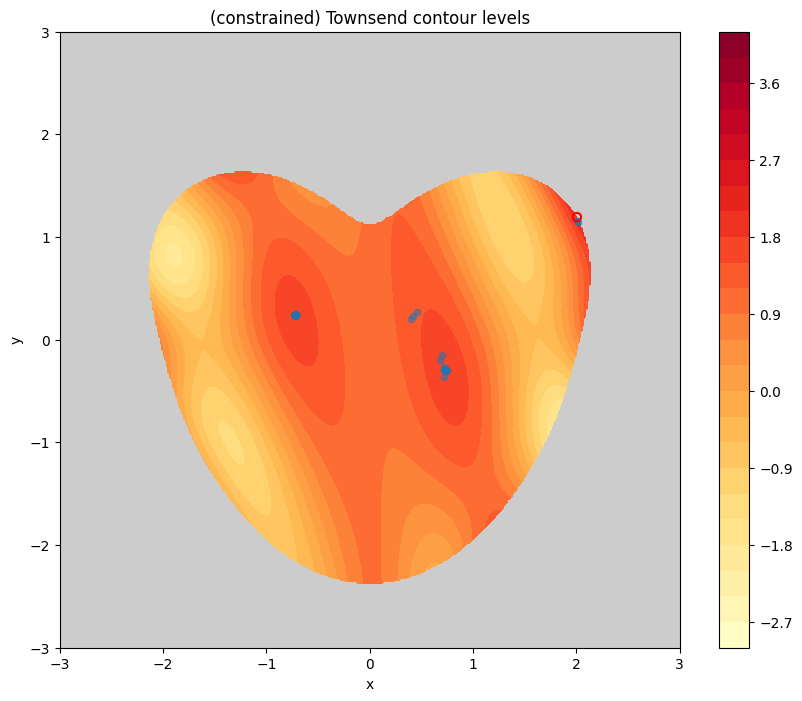

In [ ]:
results_df = pd.read_csv('results.csv', usecols=['x','y','target'])
first50 = results_df.iloc[:50]
results_df = results_df.iloc[50:].reset_index(drop = True)
print(f'first occurrence of maximum at iteration: {np.where(results_df['target'] == optimizer.max['target'])[0][0]}')
valid_mask = np.where(results_df['target'] <= optimizer.max['target'])[0]
x_iter = results_df['x'].iloc[valid_mask]
y_iter = results_df['y'].iloc[valid_mask]

sampled = [x_iter, y_iter]
# meshgrid
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)

Z_target = target(X, Y)
Z_constraint = constraint(X, Y)

# target contour levels
plt.figure(figsize=(10, 8))
contour_target = plt.contourf(X, Y, Z_target, levels=25,cmap='YlOrRd') # Use 100 levels for smooth gradients
plt.colorbar(contour_target)

# constraint contour levels (only 2: >0 or <=0)
# grey for <= 0, transparent for > 0
plt.contourf(X, Y, Z_constraint <= 0, levels=[-np.inf, 0, np.inf], colors=['0.8', 'none'])
plt.scatter(x_iter, y_iter, s=20, alpha = 0.5)
plt.scatter(2.0052938, 1.1944509, edgecolors='red', facecolors='none', linewidths=1.5)
plt.scatter(first50['x'], first50['y'], s = 10, color = 'red')

plt.xlabel('x')
plt.ylabel('y')
plt.title('(constrained) Townsend contour levels')
plt.show()

In [54]:
print(len([x for x in x_iter if x < 0]))

97


# (acq: 'eb', fixed gamma = 10)


In [ ]:
import warnings
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y, show_minimized=False, style='transparent'):

    if style == 'classic':
        plt.style.use(style)
    elif style == 'dark':
        plt.style.use('dark_background')
    elif style == 'transparent':
        pass
    else:
        raise ValueError("Wrong style")

    # Swap sign of stuff
    sign = -1 if show_minimized else 1
    
    # Set up complete plot
    plt.rcParams.update({'font.size': 20})

    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    ## MAIN PLOT
    # Plot true objective
    target_col = 'limegreen' if style == 'dark' else 'gray'
    axis.plot(x, sign*y, linewidth=3.5, label='objective function',
              color=target_col)
    # Plot observations
    x_obs = np.array([[res["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    axis.scatter(x_obs, sign*y_obs, marker='o', s=300,
                 label='observations', color='red', zorder=10)   
    # Plot mean function
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    mu = sign * mu
    axis.plot(x, mu, dashes=(12, 3.5), color='blue', lw=2.5, label='mean prediction')
    # Plot credible interval
    quant = 1.96
    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - quant * sigma, (mu + quant * sigma)[::-1]]),
        alpha=.6, fc='paleturquoise', ec='None', label='95% credible interval')
    # Set parameters
    xlim = (-2,10)
    axis.set_xlim(xlim)
    axis.set_xlabel('x')
    axis.set_ylim(-1.61, 0.01)
    axis.set_ylabel('objective function')
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

    ## ACQUISITION PLOT
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    x_next = x[np.argmax(utility)]
    print(x_next)
    acq.plot(x, utility, label='acquisition function', lw=2, color='fuchsia')
    acq.scatter(x_next, np.max(utility), marker='x', s=300, 
             label='next observation', ec='red', lw=4, zorder=10)
    acq.set_xlim(xlim)
    acq.set_ylim((0, 2.501))
    acq.set_ylabel('utility')
    acq.set_xlabel('x')
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1))

    # Vertical lines in both
    axis.vlines(x_next, sign*0, sign*1.6, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')
    acq.vlines(x_next,       0,        5, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')

    # Overlay vertical Gaussian distribution
    ypos_idx = np.abs(x-x_next).argmin()
    ypos = mu[ypos_idx]
    var = 0.6 * sigma[ypos_idx]  # I'm cheating a little bit with the variance
                                 # for representation purposes
    bound = 0.5
    supp = np.linspace(-bound, bound, 1000).reshape(-1, 1)
    gaussian = np.exp((-supp ** 2.0) / (2 * var ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= -0.5  # height
    axis.plot(gaussian + x_next, supp + ypos, lw=1.5, color='silver')

    # Save to file
    for fmt in ('png', 'svg'):
        filename = f'bo_{style}_{len(x_obs)}.{fmt}'
        plt.savefig(os.path.join('resources', filename), bbox_inches='tight', dpi=300)

# with these values it converges seed = 27122
optimizer = BayesianOptimization(target, {'x': (-2.25,2.5),'y': (-2.5,1.75)}, 
                                 random_state=27222,
                                 barrier_func={'constraint1': lambda x,y: x**2+y**2-(2*np.cos(np.arctan2(x,y))-0.5*np.cos(2*np.arctan2(x,y))-0.25*np.cos(3*np.arctan2(x,y))-0.125*np.cos(4*np.arctan2(x,y)))**2-(2*np.sin(np.arctan2(x,y)))**2},
                                 debug = True)
# Other rounds of optimization
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    warnings.simplefilter("ignore", FutureWarning)
    optimizer.maximize(init_points=50, n_iter=120,acq='eb',acq_info={'static_lambda':True, 'lam': 1e-1})
    # optimizer.maximize(init_points=50, n_iter=120,acq='eic_bm',acq_info={'static_lambda':True, 'lam':10})

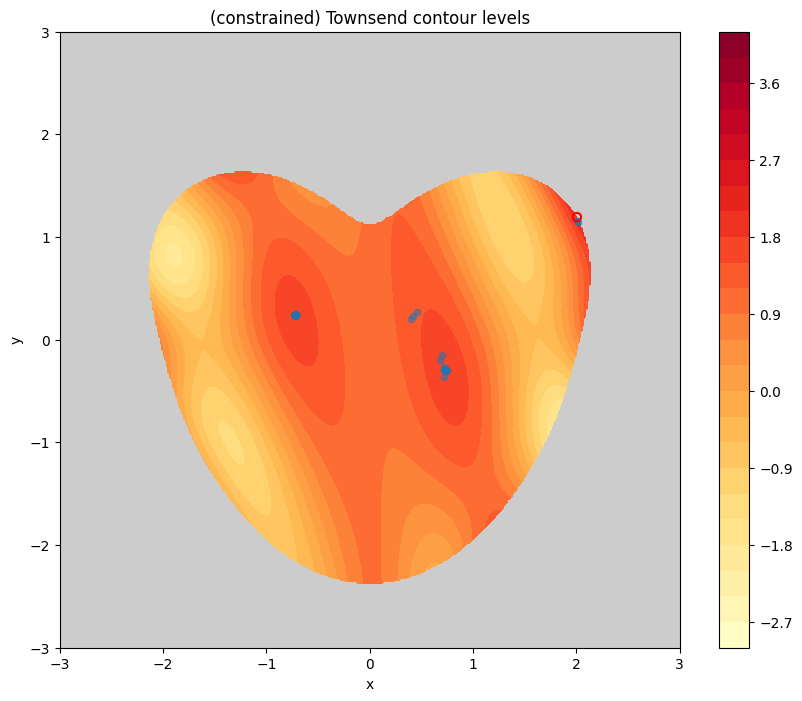

In [86]:
results_df = pd.read_csv('results.csv', usecols=['x','y','target'])
first50 = results_df.iloc[50:]
results_df = results_df.iloc[50:].reset_index(drop = True)
print(f'first occurrence of maximum at iteration: {np.where(results_df['target'] == optimizer.max['target'])[0][0]}')
valid_mask = np.where(results_df['target'] <= optimizer.max['target'])[0]
x_iter = results_df['x'].iloc[valid_mask]
y_iter = results_df['y'].iloc[valid_mask]

sampled = [x_iter, y_iter]
# meshgrid
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)

Z_target = target(X, Y)
Z_constraint = constraint(X, Y)

# target contour levels
plt.figure(figsize=(10, 8))
contour_target = plt.contourf(X, Y, Z_target, levels=25,cmap='YlOrRd') # Use 100 levels for smooth gradients
plt.colorbar(contour_target)

# constraint contour levels (only 2: >0 or <=0)
# grey for <= 0, transparent for > 0
plt.contourf(X, Y, Z_constraint <= 0, levels=[-np.inf, 0, np.inf], colors=['0.8', 'none'])
plt.scatter(x_iter, y_iter, s=20, alpha = 0.5)
plt.scatter(2.0052938, 1.1944509, edgecolors='red', facecolors='none', linewidths=1.5)
plt.scatter(first50['x'], first50['y'], s = 10, color = 'red')

plt.xlabel('x')
plt.ylabel('y')
plt.title('(constrained) Townsend contour levels')
plt.show()

# (acq = eic_bm, gamma = 10)

In [ ]:
import warnings
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y, show_minimized=False, style='transparent'):

    if style == 'classic':
        plt.style.use(style)
    elif style == 'dark':
        plt.style.use('dark_background')
    elif style == 'transparent':
        pass
    else:
        raise ValueError("Wrong style")

    # Swap sign of stuff
    sign = -1 if show_minimized else 1
    
    # Set up complete plot
    plt.rcParams.update({'font.size': 20})

    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    ## MAIN PLOT
    # Plot true objective
    target_col = 'limegreen' if style == 'dark' else 'gray'
    axis.plot(x, sign*y, linewidth=3.5, label='objective function',
              color=target_col)
    # Plot observations
    x_obs = np.array([[res["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    axis.scatter(x_obs, sign*y_obs, marker='o', s=300,
                 label='observations', color='red', zorder=10)   
    # Plot mean function
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    mu = sign * mu
    axis.plot(x, mu, dashes=(12, 3.5), color='blue', lw=2.5, label='mean prediction')
    # Plot credible interval
    quant = 1.96
    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - quant * sigma, (mu + quant * sigma)[::-1]]),
        alpha=.6, fc='paleturquoise', ec='None', label='95% credible interval')
    # Set parameters
    xlim = (-2,10)
    axis.set_xlim(xlim)
    axis.set_xlabel('x')
    axis.set_ylim(-1.61, 0.01)
    axis.set_ylabel('objective function')
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

    ## ACQUISITION PLOT
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    x_next = x[np.argmax(utility)]
    print(x_next)
    acq.plot(x, utility, label='acquisition function', lw=2, color='fuchsia')
    acq.scatter(x_next, np.max(utility), marker='x', s=300, 
             label='next observation', ec='red', lw=4, zorder=10)
    acq.set_xlim(xlim)
    acq.set_ylim((0, 2.501))
    acq.set_ylabel('utility')
    acq.set_xlabel('x')
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1))

    # Vertical lines in both
    axis.vlines(x_next, sign*0, sign*1.6, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')
    acq.vlines(x_next,       0,        5, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')

    # Overlay vertical Gaussian distribution
    ypos_idx = np.abs(x-x_next).argmin()
    ypos = mu[ypos_idx]
    var = 0.6 * sigma[ypos_idx]  # I'm cheating a little bit with the variance
                                 # for representation purposes
    bound = 0.5
    supp = np.linspace(-bound, bound, 1000).reshape(-1, 1)
    gaussian = np.exp((-supp ** 2.0) / (2 * var ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= -0.5  # height
    axis.plot(gaussian + x_next, supp + ypos, lw=1.5, color='silver')

    # Save to file
    for fmt in ('png', 'svg'):
        filename = f'bo_{style}_{len(x_obs)}.{fmt}'
        plt.savefig(os.path.join('resources', filename), bbox_inches='tight', dpi=300)

# with these values it converges seed = 27122
optimizer = BayesianOptimization(target, {'x': (-2.25,2.5),'y': (-2.5,1.75)}, 
                                 random_state=27222,
                                 barrier_func={'constraint1': lambda x,y: x**2+y**2-(2*np.cos(np.arctan2(x,y))-0.5*np.cos(2*np.arctan2(x,y))-0.25*np.cos(3*np.arctan2(x,y))-0.125*np.cos(4*np.arctan2(x,y)))**2-(2*np.sin(np.arctan2(x,y)))**2},
                                 debug = True)
# Other rounds of optimization
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    warnings.simplefilter("ignore", FutureWarning)
    optimizer.maximize(init_points=50, n_iter=200,acq='eic_bm',acq_info={'static_lambda':True, 'lam': 1e-1})
    # optimizer.maximize(init_points=50, n_iter=120,acq='eic_bm',acq_info={'static_lambda':True, 'lam':10})

In [ ]:
results_df = pd.read_csv('results.csv', usecols=['x','y','target'])
first50 = results_df.iloc[50:]
results_df = results_df.iloc[50:].reset_index(drop = True)
print(f'first occurrence of maximum at iteration: {np.where(results_df['target'] == optimizer.max['target'])[0][0]}')
valid_mask = np.where(results_df['target'] <= optimizer.max['target'])[0]
x_iter = results_df['x'].iloc[valid_mask]
y_iter = results_df['y'].iloc[valid_mask]

sampled = [x_iter, y_iter]
# meshgrid
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)

Z_target = target(X, Y)
Z_constraint = constraint(X, Y)

# target contour levels
plt.figure(figsize=(10, 8))
contour_target = plt.contourf(X, Y, Z_target, levels=25,cmap='YlOrRd') # Use 100 levels for smooth gradients
plt.colorbar(contour_target)

# constraint contour levels (only 2: >0 or <=0)
# grey for <= 0, transparent for > 0
plt.contourf(X, Y, Z_constraint <= 0, levels=[-np.inf, 0, np.inf], colors=['0.8', 'none'])
plt.scatter(x_iter, y_iter, s=20, alpha = 0.5)
plt.scatter(2.0052938, 1.1944509, edgecolors='red', facecolors='none', linewidths=1.5)
plt.scatter(first50['x'], first50['y'], s = 10, color = 'red')

plt.xlabel('x')
plt.ylabel('y')
plt.title('(constrained) Townsend contour levels')
plt.show()